# Библиотеки

In [1]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install beautifulsoup4

In [3]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import sys
import csv
import re
import time
import requests
from datetime import datetime
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
import seaborn as sns
import matplotlib.pyplot as plt 

# Функции

In [2]:
def get_key(count, value):
    '''Функция предназначена для возвращения ключей по конктретному значению (value) в словарях'''
    keys = []
    for k, v in count.items():
        if v == value:
            keys.append(k)
    return keys

# Загрузка Pandas и очистка данных

In [3]:
# Загрузка датасета
restorans = pd.read_csv("../main_task_new.csv")
restorans.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [4]:
# Приведем названия столбцов к одному виду.
restorans.columns = restorans.columns.map(lambda x: x.replace(" ", "_"))
restorans.columns

Index(['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Rating',
       'Price_Range', 'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [5]:
# В данных присутствует три числовых призника, где столбец Rating является целевой переменной.
restorans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine_Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price_Range        26114 non-null  object 
 6   Number_of_Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
# Создадим функцию, которая ищет столбцы с NaN.
def nan_finder(df):
    '''Функция предназначена для нахождения пустых значений с помошью метода isnull()'''
    nan_columns = []
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            nan_columns.append(column)
    return nan_columns

In [7]:
# Выведем столбцы с пропусками.
nan_finder(restorans)

['Cuisine_Style', 'Price_Range', 'Number_of_Reviews']

In [8]:
# Разберемся с пропусками в столбце Cuisine_Style.
restorans['Cuisine_Style'].isnull().sum()

9283

In [9]:
# Возьмем недостающие данные в столбце Cuisine_Style с сайтов ресторанов, они указаны в столбце URL_TA.
# Преобразуем адресную строку.
urls = []

for url in restorans['URL_TA']:
    urls.append('http://www.tripadvisor.com' + url)
    
restorans['URL_TA'] = urls

In [20]:
# Добавляем путь к файлу, в котором будут сохраняться данные.
path_to_file = "C:/Users/a9251/Desktop/data.csv"

# Открываем файл для записи данных.
csvFile = open(path_to_file, 'a', encoding="utf-8")
csvWriter = csv.writer(csvFile)

# Импортируем вебдрайвер для браузера.
s = Service('C:/Users/a9251/Downloads/chromedriver.exe')
browser = webdriver.Chrome(service=s)

# Задаем данные сайтов, соответствующих пропущенным значениям в столбце Cuisine_Style.
for i in restorans[restorans['Cuisine_Style'].isnull()]['URL_TA']:
    url = i
    page = browser.get(url)

    time.sleep(2)
    container = browser.find_elements(By.CLASS_NAME, "drUyy")
    csvWriter.writerow([el.get_property('text') for el in container])

browser.close()

In [10]:
# Открываем получившийся Excel файл с данными о кухнях. Как видно не у всех ресторанов указана эта информация.
data_file = pd.ExcelFile(".../data.xlsx")  
data = pd.read_excel(data_file)
data.head(10)

,Cuisine_Style
0,"Asian, Nepali"
1,NaN
2,"Bar, European, Portuguese"
3,"Cafe, European"
4,"Mediterranean, Spanish"
5,NaN
6,"Spanish, WineBar"
7,NaN
8,NaN
9,"Bar, Mediterranean, Spanish"


In [11]:
# Заменяем пропуски полученными данными.
list_of_cuisines = []
for i in data['Cuisine_Style']:
    list_of_cuisines.append(i)
    
restorans.loc[restorans['Cuisine_Style'].isnull(), 'Cuisine_Style'] = list_of_cuisines

In [12]:
# Получилось восстановить около половины пропущенных значений.
restorans['Cuisine_Style'].isnull().sum()

4838

In [13]:
# В столбце Number_of_Reviews не очень много пустых элементов.
restorans['Number_of_Reviews'].isnull().sum()

2543

In [14]:
# Заменим их средним значением.
num = round(restorans['Number_of_Reviews'].mean())
restorans['Number_of_Reviews'] = restorans['Number_of_Reviews'].fillna(num)

In [15]:
# Рассмотрим колонку Price_Range, в ней встречается три типа уровня цен.
restorans['Price_Range'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [16]:
# Поменяем данные со строковых на категориальные, где 1 - это самый низкий уровень цен,
# 3 - самый высокий.
restorans['Price_Range'] = restorans['Price_Range'].apply(lambda x: 1.0 if x == '$'
                                                          else 2.0 if x == '$$ - $$$' else 3.0 if x == '$$$$' else x)

In [17]:
# Больше всего ресторанов имеют стредний уровень цен.
restorans['Price_Range'].value_counts()

2.0    18412
1.0     6279
3.0     1423
Name: Price_Range, dtype: int64

In [18]:
# В колонке Price_Range очень много пропущенных значений.
restorans['Price_Range'].isnull().sum()

13886

In [19]:
# Проанализировав зависимость уровня цен от количества отзывов и от колонки Ranking,
# можно сделать вывод, что, в среднем, чем больше отзывов о ресторане, тем выше уровень цен,
# обратная зависимость наблюдается в колонке Ranking - чем меньше величина, тем выше уровень цен.

#restorans.query('Price_Range == 3.0')['Number_of_Reviews'].mean()
#=>380.76508620689657
#restorans.query('Price_Range == 1.0')['Number_of_Reviews'].mean()
#=>94.6063882063882
#restorans.query('Price_Range == 2.0')['Number_of_Reviews'].mean()
#=>187.20964994229817

In [20]:
# Заментим пропуски в колонке Price_Range исходя из выявленной зависимости.
def fix(x):
    '''Функция предназначена для замены пустых значений в колонке Price_Range, 
       в зависимости от количества отзывов о ресторане'''
    if (np.isnan(x['Price_Range'])) and (x['Number_of_Reviews'] <= 95.0):
        return 1.0
    elif (np.isnan(x['Price_Range'])) and (x['Number_of_Reviews'] <= 380.8):
        return 2.0
    else:
        return 3.0

restorans['Price_Range']=restorans.apply(lambda x: fix(x), axis=1)

In [21]:
# Применим к столбцу Price_Range концепцию dummy variables.
dummies = pd.get_dummies(restorans['Price_Range'])
restorans = pd.concat([restorans, dummies], axis = 1)

In [22]:
# Рассмотрим колонку City
restorans['City'].unique()

array(['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 'Oporto',
       'Milan', 'Bratislava', 'Vienna', 'Rome', 'Barcelona', 'Madrid',
       'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens',
       'Luxembourg', 'Krakow'], dtype=object)

In [23]:
# Для колонки City создадим категориальный признак с помощью one-hot-кодирования.
one = OneHotEncoder(sparse = False)
new_one_features = one.fit_transform(restorans.City.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['City№' + str(i) for i in range(new_one_features.shape[1])])
restorans = pd.concat([restorans, tmp], axis = 1) 

In [24]:
# Переименуем колонки в соответствии с названием городов.
columns = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Rating', 'Price_Range', 
           'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'Low_price', 'Average_price', 'High_price', 
           'Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 
           'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki', 'Krakow', 'Lisbon', 
           'Ljubljana', 'London', 'Luxembourg', 'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto', 
           'Oslo', 'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich']
restorans.columns = columns

In [25]:
# Создадим новый признак - количество ресторанов в городе.
num = restorans['City'].value_counts().to_dict()
restorans['Number_of_Rest'] = restorans.City.apply(lambda x: num[x])

In [26]:
# Создадим новый признак - население (количество человек в миллионах)
city_dict = {'Paris':'2.24', 'Stockholm':'1.98', 'London':'8.96', 'Berlin':'3.32', 'Munich':'1.36', 
             'Oporto':'0.21', 'Milan':'1.33', 'Bratislava':'0.42', 'Vienna':'1.9', 'Rome':'2.87', 
             'Barcelona':'1.6', 'Madrid':'3.22', 'Dublin':'0.54', 'Brussels':'0.18', 'Zurich':'0.4', 
             'Warsaw':'1.77', 'Budapest':'1.76', 'Copenhagen':'0.6', 'Amsterdam':'0.82', 'Lyon':'0.51', 
             'Hamburg':'1.84', 'Lisbon':'0.5', 'Prague':'1.3', 'Oslo':'0.63', 'Helsinki':'0.63', 
             'Edinburgh':'0.48', 'Geneva':'0.2', 'Ljubljana':'0.28', 'Athens':'0.66', 'Luxembourg':'0.63', 
             'Krakow':'0.77',
}
city_dict
restorans['Number_of_People'] = restorans.City.apply(lambda x: city_dict[x])

In [27]:
# Переведем данные в формат float
restorans['Number_of_People'] = [float(i) for i in restorans['Number_of_People'].values]

In [28]:
# Проанализируем данные в колонке Reviews.
restorans['Reviews'][0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [29]:
# Разделим отзывы и даты отзывов на две колонки.
date_regex=r'\b(0[1-9]|1[012])[- /.](0[1-9]|[12][0-9]|3[01])[- /.](19|20\d\d)\b'
dates = []
for review in restorans['Reviews']:
    date = re.findall(date_regex, review)
    dates.append(['/'.join(map(str, x)) for x in date])

restorans['Date_of_Reviews'] = dates

In [30]:
reviews_regex=r'[A-Za-z]+'
reviews = []
for review in restorans['Reviews']:
    result = re.findall(reviews_regex, review)
    reviews.append([''.join(map(str, x)) for x in result])

restorans['Reviews'] = reviews

In [31]:
# Уберем заглавные буквы в отзывах
restorans['Reviews'] = restorans['Reviews'].apply(lambda x: [w.lower() for w in x])

In [32]:
def good_reviews(x):
    '''Функция предназначена для нахождения в столбце Reviews позитивных слов из заданных в списке good_reviews, 
       если слово присутствует, то функция вернет единицу'''
    good_reviews = ['good', 'unique', 'best', 'great', 'lovely', 'nice', 'cool', 'amazing', 'enjoy', 
                    'awesome', 'excellent', 'cosy', 'beautiful', 'tasty', 'delicious', 'love','charming', 
                    'friendly', 'perfect', 'yummy']
    for i in good_reviews:
        for review in x["Reviews"]:
            if i in review:
                return 1        

In [33]:
# Получим примерную оценку отзывам
restorans['GoB_reviews'] = restorans.apply(lambda x: good_reviews(x), axis=1)

In [34]:
restorans['GoB_reviews'].fillna(0, inplace=True)

In [35]:
# Добавим новую колонку - количество слов в отзыве.
review_length = restorans["Reviews"].apply(len)
restorans['Review_Length'] = review_length.values 

In [36]:
# Найдем дату последнего оставленного отзыва.
datetime_list = []
for dates in restorans['Date_of_Reviews'].values:
    for date in dates:
        datetime_list.append(datetime.strptime(date, '%m/%d/%Y'))
print(max(datetime_list))

2018-02-26 00:00:00


In [37]:
# Для удобства разделим колонку Date_of_Reviews на две.
restorans['Date_of_Reviews'] = [str(i) for i in restorans['Date_of_Reviews'].values]
restorans['Date_of_Reviews'] = restorans['Date_of_Reviews'].str.strip('[]')
restorans[['Date_№1', 'Date_№2']] = restorans['Date_of_Reviews'].str.split(', ', 1, expand=True)

In [38]:
# Приведем колонки к формату datetime.
restorans['Date_№1'] = restorans['Date_№1'].apply(lambda x: x.replace("'",""))
restorans['Date_№2'] = restorans['Date_№2'].fillna('')
restorans['Date_№2'] = restorans['Date_№2'].apply(lambda x: x.replace("'",""))
restorans["Date_№1"] = pd.to_datetime(restorans["Date_№1"])
restorans["Date_№2"] = pd.to_datetime(restorans["Date_№2"])

In [39]:
# Проверим колонки с датами отзывов на выбросы воспользовавшись формулой интерквартильного расстояния.
IQR = restorans["Date_№1"].quantile(0.75) - restorans["Date_№1"].quantile(0.25)
perc25 = restorans["Date_№1"].quantile(0.25)
perc75 = restorans["Date_№1"].quantile(0.75)
 
print(
'25-й перцентиль: {},'.format(perc25),
'75-й перцентиль: {},'.format(perc75),
"IQR: {}, ".format(IQR),
"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 2017-03-08 00:00:00, 75-й перцентиль: 2017-12-06 00:00:00, IQR: 273 days 00:00:00,  Границы выбросов: [2016-01-23 12:00:00, 2019-01-19 12:00:00].


In [40]:
IQR = restorans["Date_№2"].quantile(0.75) - restorans["Date_№2"].quantile(0.25)
perc25 = restorans["Date_№2"].quantile(0.25)
perc75 = restorans["Date_№2"].quantile(0.75)
 
print(
'25-й перцентиль: {},'.format(perc25),
'75-й перцентиль: {},'.format(perc75),
"IQR: {}, ".format(IQR),
"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 2016-11-17 00:00:00, 75-й перцентиль: 2017-11-01 00:00:00, IQR: 349 days 00:00:00,  Границы выбросов: [2015-06-12 12:00:00, 2019-04-08 12:00:00].


In [41]:
# Удалим строки с датами отзывов, которые выходят за границу выбросов.
restorans = restorans[restorans["Date_№1"].dt.year >= 2015]
restorans = restorans[restorans["Date_№2"].dt.year >= 2015]

In [42]:
# Создадаим новую колонку - количество дней между первыми двумя отзывами
restorans['Delta'] = restorans["Date_№1"] - restorans["Date_№2"]

In [43]:
restorans['Delta'] = [int(i) for i in restorans['Delta'].values]

In [44]:
# Проанализируем данные в колонке Cuisine_Style 
restorans['Cuisine_Style'][0]

"['European', 'French', 'International']"

In [45]:
# Удалим строки с пропущенными значениями в столбце Cuisine_Style
restorans = restorans[restorans['Cuisine_Style'].notna()]

In [46]:
# Уберем лишние символы и представим данные в виде списка
restorans['Cuisine_Style'] = restorans['Cuisine_Style'].str.strip('[]')
restorans['Cuisine_Style'] = restorans['Cuisine_Style'].apply(lambda x: x.replace("'",""))
restorans['Cuisine_Style'] = restorans['Cuisine_Style'].apply(lambda x: x.split(", "))

In [47]:
# Найдем количество разных типов кухнь в данных.
list_of_cuisines = set()
for cuisines in restorans["Cuisine_Style"]:
    for cuisine in cuisines:
        list_of_cuisines.add(cuisine)
len(list_of_cuisines)

151

In [48]:
# Найдем самую популярную кухню.
count = Counter()
for cuisines in restorans["Cuisine_Style"]:
    for cuisine in cuisines:
        count[cuisine] += 1
        
max_cuisine = max(count.values())
print(get_key(count, max_cuisine))

['Vegetarian Friendly']


In [49]:
# Сгруппируем кухни по происхождению для создания новых признаков.
north_america = ['Fast Food', 'FastFood', 'American', 'Hawaiian', 'Barbecue', 'Central American', 'CentralAmerican',
                 'Canadian', 'Native American', 'Steakhouse', 'Gastropub', 'QuickBites',
                 'Salvadoran', 'Cajun & Creole', 'Cajun&Creole', 'Southwestern']
south_america = ['Mexican', 'South American', 'SouthAmerican', 'Latin', 'Brazilian', 'Argentinean', 
                 'Peruvian', 'Venezuelan', 'Chilean', 'Ecuadorean', 'Colombian']
northern_europe = ['Scandinavian', 'Danish', 'Swedish', 'Norwegian', 'Latvian', 
                   'Caribbean', 'Cuban', 'Venezuelan']
western_europe = ['British', 'Central European', 'CentralEuropean', 'German', 'Dutch', 'Irish', 
                  'Belgian', 'Swiss', 'Scottish', 'European', 'French', 'Austrian', 'Welsh']
eastern_europe = ['Czech', 'Eastern European', 'EasternEuropean', 'Polish', 'Hungarian', 'Russian', 'Ukrainian', 
                  'Balti', 'Romanian']
southern_europe = ['Portuguese', 'Greek', 'Slovenian', 'Spanish', 'Italian', 'Pizza', 'Basque', 'CentralItalian',
                   'Albanian', 'Mediterranean', 'Croatian', 'Catalan', 'Emilian', 'Lazio', 'Lombard', 'Neapolitan',
                   'NorthernItalian', 'Romagna', 'Romana', 'SouthernItalian']
east_and_central_asia = ['Minority Chinese', 'Chinese', 'Sushi', 'Japanese', 'Central Asian', 'Korean', 
                         'Taiwanese', 'Seafood', 'Asian', 'Tibetan', 'Mongolian', 'Fujian', 'Yunnan', 
                         'Xinjiang', 'BeijingSpecialties', 'Cantonese', 'Central Asian', 'JapaneseFusion', 'Xinjiang']
south_asia = ['Indian', 'Pakistani', 'Bangladeshi', 'Sri Lankan', 'Jamaican', 'Nepali']
western_asia = ['Israeli', 'Turkish', 'Azerbaijani', 'Armenian', 'Halal', 'Middle Eastern', 'Deli', 'MiddleEastern',
                'Lebanese', 'Georgian', 'Persian', 'Kosher']
сaucasus = ['Uzbek', 'Afghani', 'Caucasian'] 
southeast_asia = ['Vietnamese', 'Thai', 'Singaporean', 'Filipino', 'Indonesian', 'Malaysian', 'Cambodian', 'Burmese']
africa = ['African', 'Moroccan', 'Tunisian', 'Egyptian', 'Arabic', 'Ethiopian']
special = ['Vegetarian Friendly', 'Vegan Options', 'VeganOptions', 'Gluten Free Options', 'Healthy', 'GlutenFreeOptions']
alcohol = ['Bar', 'Pub', 'Wine Bar', 'Brew Pub', 'BrewPub', 'Beerrestaurants', 'WineBar']
australia = ['Australian', 'New Zealand', 'Polynesian']
other_cuisines = ['Cafe', 'International', 'Fusion', 'Contemporary', 'Soups', 'Grill', 'Diningbars', 
                  'Delicatessen', 'Diner', 'Street Food', 'Bakeries', 'Campania', 'Dessert', 
                  'SpecialtyFoodMarket', 'StreetFood']

In [50]:
def cuisines(x, list_of_cuisines):
    '''Функция предназначена для нахождения в столбце Cuisine_Style кухонь из заданных в списке list_of_cuisines, 
       если кухня присутствует, то функция вернет единицу'''
    for i in list_of_cuisines:
        for cuisines in x["Cuisine_Style"]:
            if i in cuisines:
                return 1

In [51]:
# Создаем новые признаки на основе вышезаданных списков кухонь, применяя функцию cuisines(x, list_of_cuisines).
restorans['North_America']=restorans.apply(lambda x: cuisines(x, north_america), axis=1)
restorans['South_America']=restorans.apply(lambda x: cuisines(x, south_america), axis=1)
restorans['Northern_Europe']=restorans.apply(lambda x: cuisines(x, northern_europe), axis=1)
restorans['Western_Europe']=restorans.apply(lambda x: cuisines(x, western_europe), axis=1)
restorans['Eastern_Europe']=restorans.apply(lambda x: cuisines(x, eastern_europe), axis=1)
restorans['Southern_Europe']=restorans.apply(lambda x: cuisines(x, southern_europe), axis=1)
restorans['East_and_Central_Asia']=restorans.apply(lambda x: cuisines(x, east_and_central_asia), axis=1)
restorans['South_Asia']=restorans.apply(lambda x: cuisines(x, south_asia), axis=1)
restorans['Western_Asia']=restorans.apply(lambda x: cuisines(x, western_asia), axis=1)
restorans['Caucasus']=restorans.apply(lambda x: cuisines(x, сaucasus), axis=1)
restorans['Southeast_Asia']=restorans.apply(lambda x: cuisines(x, southeast_asia), axis=1)
restorans['Africa']=restorans.apply(lambda x: cuisines(x, africa), axis=1)
restorans['Special']=restorans.apply(lambda x: cuisines(x, special), axis=1)
restorans['Alcohol']=restorans.apply(lambda x: cuisines(x, alcohol), axis=1)
restorans['Australia']=restorans.apply(lambda x: cuisines(x, australia), axis=1)
restorans['Other_Cuisines']=restorans.apply(lambda x: cuisines(x, other_cuisines), axis=1)

In [52]:
# Заполняем пропуски в новых признаках.
restorans['North_America'].fillna(0, inplace=True)
restorans['South_America'].fillna(0, inplace=True)
restorans['Northern_Europe'].fillna(0, inplace=True)
restorans['Western_Europe'].fillna(0, inplace=True)
restorans['Eastern_Europe'].fillna(0, inplace=True)
restorans['Southern_Europe'].fillna(0, inplace=True)
restorans['East_and_Central_Asia'].fillna(0, inplace=True)
restorans['South_Asia'].fillna(0, inplace=True)
restorans['Western_Asia'].fillna(0, inplace=True)
restorans['Caucasus'].fillna(0, inplace=True)
restorans['Southeast_Asia'].fillna(0, inplace=True)
restorans['Africa'].fillna(0, inplace=True)
restorans['Special'].fillna(0, inplace=True)
restorans['Alcohol'].fillna(0, inplace=True)
restorans['Australia'].fillna(0, inplace=True)
restorans['Other_Cuisines'].fillna(0, inplace=True)

In [53]:
# Добавим новую колонку - количество типов кухонь в ресторане.
Number_of_cuisines = restorans["Cuisine_Style"].apply(len)
restorans['Number_of_cuisines'] = Number_of_cuisines.values 

In [54]:
# Найдем среднее количество типов кухонь, предлагаемых в одном ресторане.
restorans['Number_of_cuisines'].mean()

3.3555990633037736

In [55]:
df = restorans.copy()
df = df.drop(['Restaurant_id', 'City', 'Cuisine_Style', 'Reviews', 'URL_TA', 'ID_TA', 'Price_Range', 
              'Date_of_Reviews'], axis = 1)

In [56]:
# Все данные являются числовыми
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26049 entries, 0 to 39998
Data columns (total 61 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Ranking                26049 non-null  float64       
 1   Rating                 26049 non-null  float64       
 2   Number_of_Reviews      26049 non-null  float64       
 3   Low_price              26049 non-null  uint8         
 4   Average_price          26049 non-null  uint8         
 5   High_price             26049 non-null  uint8         
 6   Amsterdam              26049 non-null  float64       
 7   Athens                 26049 non-null  float64       
 8   Barcelona              26049 non-null  float64       
 9   Berlin                 26049 non-null  float64       
 10  Bratislava             26049 non-null  float64       
 11  Brussels               26049 non-null  float64       
 12  Budapest               26049 non-null  float64       
 13  C

In [57]:
Corr_df = df[['Ranking', 'Rating', 'Number_of_Reviews', 'Low_price', 'High_price', 'Amsterdam', 'Krakow', 
              'Number_of_Rest', 'Review_Length', 'North_America', 'South_Asia', 'Special', 'Average_price',
              'Number_of_cuisines', 'Eastern_Europe', 'Copenhagen', 'GoB_reviews', 'Western_Europe']]
Corr_df.head(7)

,Ranking,Rating,Number_of_Reviews,Low_price,High_price,Amsterdam,Krakow,Number_of_Rest,Review_Length,North_America,South_Asia,Special,Average_price,Number_of_cuisines,Eastern_Europe,Copenhagen,GoB_reviews,Western_Europe
0,5570.0,3.5,194.0,0,1,0.0,0.0,4897,9,0.0,0.0,0.0,0,3,0.0,0.0,1.0,1.0
1,1537.0,4.0,10.0,1,0,0.0,0.0,820,5,0.0,1.0,0.0,0,2,0.0,0.0,1.0,0.0
2,353.0,4.5,688.0,0,1,0.0,0.0,5757,6,0.0,0.0,1.0,0,7,0.0,0.0,0.0,0.0
4,621.0,4.0,84.0,0,1,0.0,0.0,893,14,0.0,0.0,1.0,0,3,0.0,0.0,1.0,1.0
5,1419.0,3.0,2.0,1,0,0.0,0.0,513,13,0.0,0.0,0.0,0,3,0.0,0.0,1.0,1.0
6,1722.0,4.0,50.0,0,1,0.0,0.0,2133,6,0.0,0.0,0.0,0,2,0.0,0.0,1.0,0.0
9,4210.0,4.0,55.0,0,1,0.0,0.0,2078,8,1.0,0.0,0.0,0,3,0.0,0.0,1.0,0.0


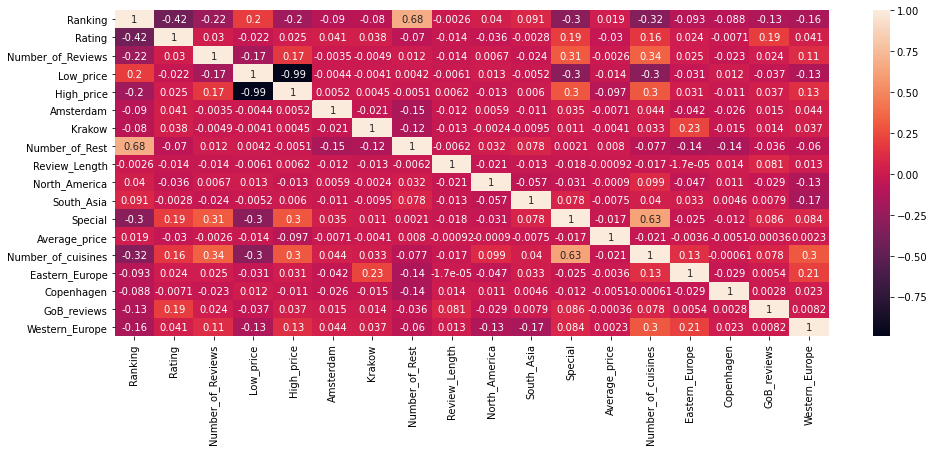

In [58]:
C = Corr_df.corr(method='pearson')
plt.figure(figsize=(16,6)) 
sns.heatmap(data = C, annot=True)

Из корреляционной таблицы видно, что столбцы Low_price и High_price сильно скоррелированны, уберем из данных один из них, 
также некоторые столбцы с кухнями очень плохо коррелируют с числовой переменной, но их выброс влияет на метрику в основном 
в разряде тысячных.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [69]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating', 'Date_№1', 'Date_№2', 'High_price', 'South_Asia'], axis = 1)
y = df['Rating']

In [60]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [70]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [62]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [71]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [72]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20414248426224474


# Выводы

В результате проекта по машинному обучению была производена очистка данных от пропусков и выбросов; 
были получены новые признаки на основе информации, уже содержащейся в данных, а также на основе информации, 
взятой из других источников; для устранения большого количества пропусков был произведен парсинг данных с
сайтов ресторанов.
После очистки данных и добавления новых признаков была создана копия датафрейма, в котором были удалены все
нечисловые столбцы; построена корреляционная матрица, на основе которой анализировались зависимости 
данных между собой, а также между целевой переменной и набором данных. 
В результате построения и обучения модели получена метрика MAE, имеющая величину 0.20.
